In [11]:
library(tidyverse)
library(ggpubr)
library(GGally)
library(yaml)
library(patchwork)
#library(Seurat)
#library(ggvenn)

#read config
config <- read_yaml(file = "../Dip_C_snakemake/config.yaml")

#Common
Raw <- read_table2("../stat/raw.fq.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X2 = X2/4*300/1000000000,X1 = strsplit(X1,split = "/")[[1]][3],X1 = strsplit(X1,split = "_")[[1]][1])

raw_pairs <- read_table2("../stat/raw.pairs.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][3])
pairs_dedup <- read_table2("../stat/pairs.dedup.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][3])

pairs_c1 <- read_table2("../stat/pairs.c1.stat",col_names=F)%>% arrange(X1) %>%rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][5]) %>% mutate(X1 = str_replace(X1,".pairs.gz",""))
pairs_c12 <- read_table2("../stat/pairs.c12.stat",col_names=F)%>% arrange(X1) %>%rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][5]) %>% mutate(X1 = str_replace(X1,".pairs.gz",""))
inter_pairs_c12 <- read_table2(file = "../stat/inter.pairs.c12.stat",col_names = F) %>% arrange(X1) %>%rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][5]) %>% mutate(X1 = str_replace(X1,".pairs.gz",""))
yperx <- read_table2("../stat/yperx.stat",col_names=F) %>% arrange(X1) %>% rowwise() %>% mutate(X1 = strsplit(X1,split = "/")[[1]][2])
stat <- Raw %>% left_join(yperx,by="X1") %>% left_join(raw_pairs,by="X1") %>% left_join(pairs_dedup,by="X1") %>% 
    left_join(pairs_c1,by="X1") %>% left_join(pairs_c12,by="X1") %>% left_join(inter_pairs_c12,by="X1")

names(stat) <- c("cellname","Rawreads","yperx","raw_pairs","pairs_dedup","pairs_clean1","pairs_clean2","inter_pairs_clean2")


if(config$if_structure){
    rmsd <- read_table2("../stat/rmsd.info",col_names = F) %>% rowwise() %>% mutate(X1=str_split(X1,pattern = fixed("/")),cellname = X1[1], res = str_split(X1[3], fixed("."))[[1]][2],TOP3_RMSD = X5) %>% select(cellname,res,TOP3_RMSD) %>% spread(res,TOP3_RMSD) %>% arrange(cellname)
    stat <- stat %>% left_join(rmsd)
}

stat <- stat %>% mutate(pairsPerRead = raw_pairs/Rawreads/1000000000*300,
                        pairsValidRatio = pairs_clean2/raw_pairs,
                        interPairsRatio = inter_pairs_clean2/pairs_clean2) 
stat[is.na(stat)]<-0


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double()
)


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double()
)


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double()
)


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double()
)


── Column specification ───────────────────

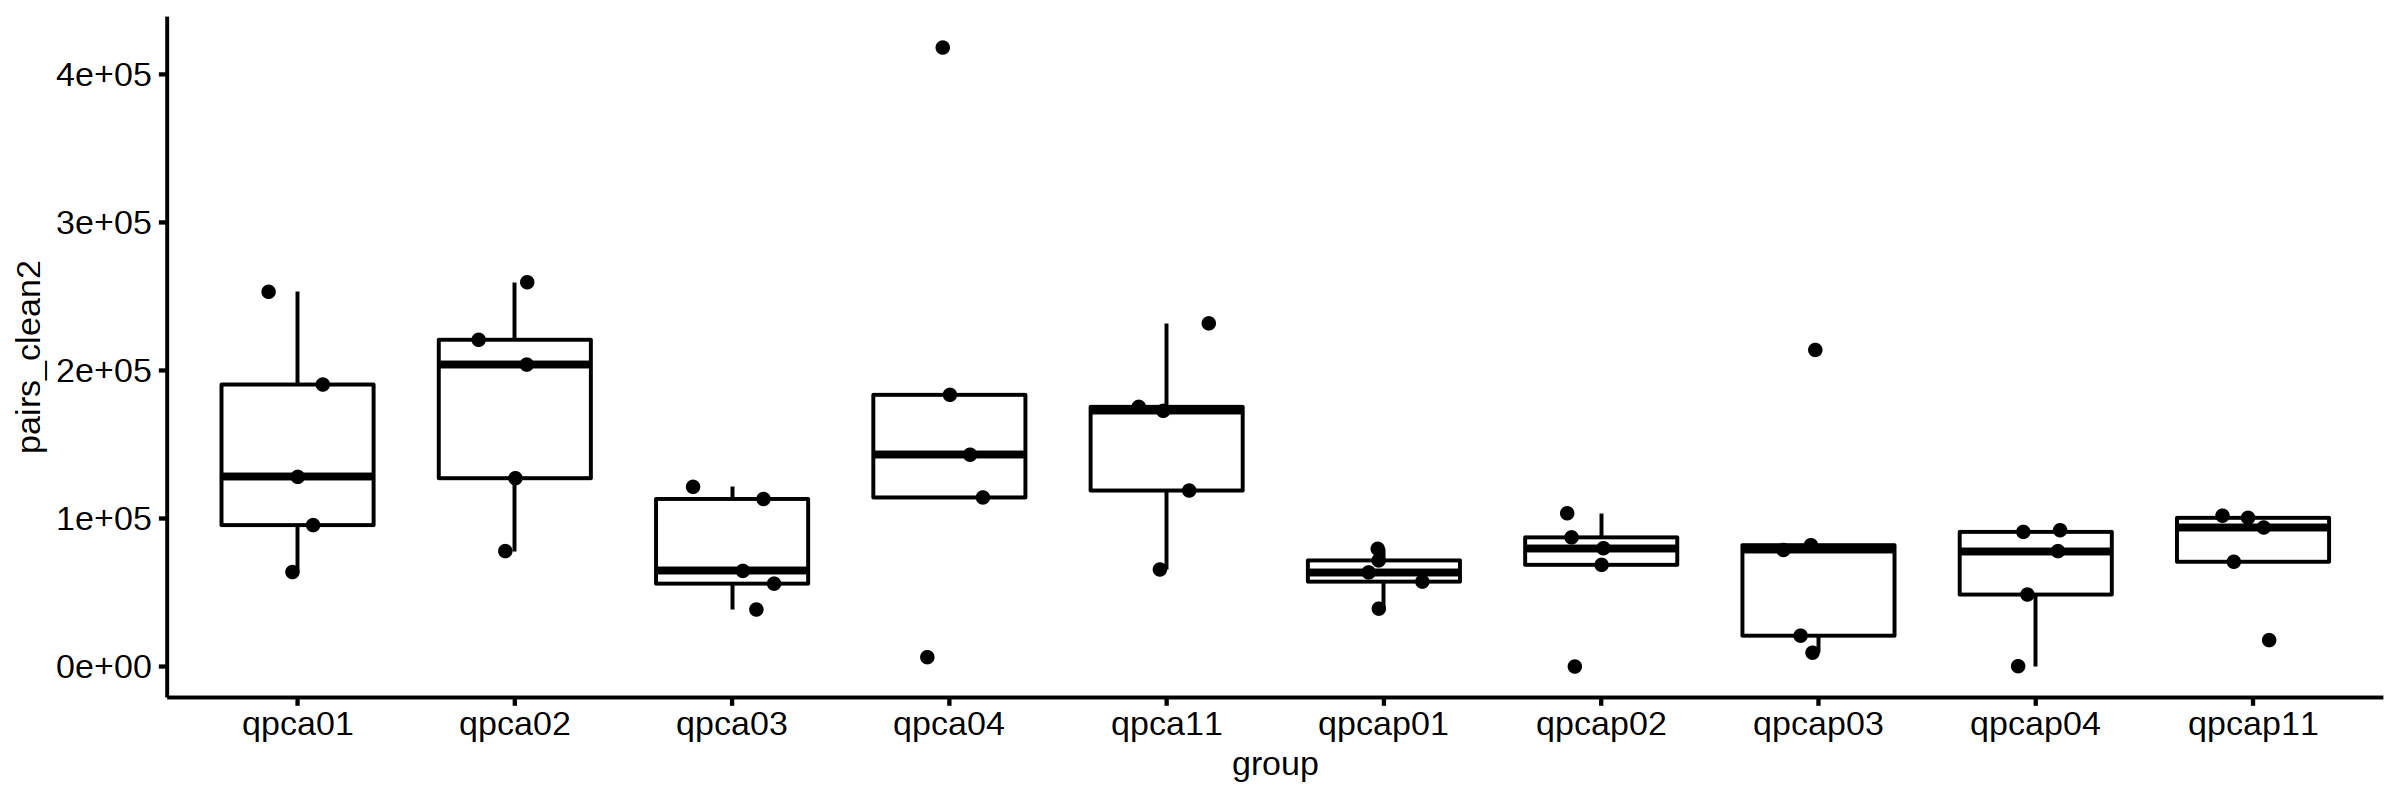

In [19]:
options(repr.plot.width = 12,repr.plot.height=4,repr.plot.res = 200)
stat %>% mutate(group = str_extract(cellname,pattern = "[a-z]+[0-9]{2}")) %>% ggboxplot(x="group",y="pairs_clean2",add = "jitter")

In [25]:
stat %>% mutate(group = str_extract(cellname,pattern = "[a-z]+[0-9]{2}")) %>% group_by(group) %>% summarise(pairs_dedup = mean(pairs_dedup))

group,pairs_dedup
<chr>,<dbl>
qpca01,166848.4
qpca02,208354.2
qpca03,138987.2
qpca04,200041.8
qpca11,182698.4
qpcap01,89949.2
qpcap02,93508.6
qpcap03,127587.4
qpcap04,81200.2
